# Install dependencies

In [2]:
!pip install -qU langchain-community langgraph langchain-anthropic langchain-openai tavily-python langgraph-checkpoint-sqlite

In [1]:
from langchain_community.tools.tavily_search import TavilySearchResults

from langchain_core.messages import HumanMessage, SystemMessage, RemoveMessage, AIMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

from langchain_openai import ChatOpenAI

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph
from langgraph.prebuilt import create_react_agent

from IPython.display import Image, display

from dotenv import load_dotenv

from time import sleep

load_dotenv()

ModuleNotFoundError: No module named 'langchain_community'

In [2]:
# Create the search tools

search = TavilySearchResults(max_results=2)
search_result = search.invoke("Who is current president of Indonesia?")
print(search_result)

tools = [search]

[{'url': 'https://www.abc.net.au/news/2024-10-20/prabowo-subianto-to-take-up-indonesian-presidency/104494762', 'content': "Former special forces commander Prabowo Subianto sworn in as Indonesian president - ABC News Prabowo Subianto was sworn in on Sunday as president of the world's third-largest democracy, Indonesia. abc.net.au/news/prabowo-subianto-to-take-up-indonesian-presidency/104494762 Indonesia's Prabowo Subianto has taken over as president of the world's third-largest democracy, months after sweeping the country's election with policies such as free meals for school children and with the outgoing leader's son as his running mate. Supporters outside the Presidential Palace watch a live feed showing Prabowo Subianto taking the oath as President of Indonesia at the parliament in Jakarta. Indonesia's election commission confirms Prabowo Subianto as the next president. A crowd of well-wishers gather outside the Presidential Palace as they wait for the inauguration of Indonesia's pr

In [3]:
llm = ChatOpenAI(
    model='gpt-3.5-turbo',
    temperature=0.5,
    max_retries=2,
    max_tokens=100
)

messages = [
    SystemMessage("Classify wether this text is Bahasa Indonesia or English"),
    HumanMessage("Hello, how are you? apakah kamu sehat?")
]

for token in llm.stream(messages):
    print(token.content, end='')
    sleep(0.1)

This text is a mix of English and Bahasa Indonesia.

In [4]:
llm_with_tools = llm.bind_tools(tools)

messages = [
    SystemMessage("Determine whether the query need a tool or not and answer accordingly"),
    HumanMessage("Berapa harga saham BBRI hari ini?")
]

res = llm_with_tools.invoke(messages)

print(res.content)
print(res.tool_calls)


[{'name': 'tavily_search_results_json', 'args': {'query': 'harga saham BBRI hari ini'}, 'id': 'call_2X2HfKwSf8nfMliMTCKZUHkx', 'type': 'tool_call'}]


In [7]:
agent = create_react_agent(llm, tools)

messages = [
    SystemMessage("Determine whether the query need a tool or not and answer accordingly"),
    HumanMessage("Berapa harga saham BMRI hari ini?")
]

res = agent.invoke({"messages": messages})

In [8]:
for message in res['messages']:
    message.pretty_print()

================================ System Message ================================

Determine whether the query need a tool or not and answer accordingly
================================ Human Message =================================

Berapa harga saham BMRI hari ini?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_Th0C3bjkD0nypUvsPhlKHYkz)
 Call ID: call_Th0C3bjkD0nypUvsPhlKHYkz
  Args:
    query: harga saham BMRI hari ini
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://id.tradingview.com/symbols/IDX-BMRI/", "content": "Jika ternyata BMRI gagal bertahan di atas area ini, saham ini berpeluang untuk bergerak turun lebih dalam me. ... Harga BMRI saat ini adalah 5.675 ... Hari ini BANK MANDIRI (PERSERO) TBK memiliki kapitalisasi pasar sebesar ‪524,37 T"}, {"url": "https://www.tradingview.com/symbols/IDX-BMRI/", "content": "BMRI

## Stream 

In [5]:

prompt = ChatPromptTemplate.from_template("Coba jelaskan mengenai {topic} maksimal 50 kata")
parser = StrOutputParser()
chain = prompt | llm | parser

async for chunk in chain.astream({"topic": "robot navigasi"}):
    print(chunk, end="", flush=True)
    if chunk == '.':
        print('\n')
    sleep(.1)

Robot navigasi adalah robot yang dilengkapi dengan sensor dan sistem navigasi yang memungkinkannya untuk bergerak secara otomatis dan menghindari rintangan.

 Robot ini dapat digunakan untuk melakukan pemetaan, survei, atau tugas-tugas lain yang memerlukan kemampuan navigasi yang akurat.



In [14]:
# Stream when using tools

# MASIH ADA ERROR 443 (SSL CERT) 

messages = [
    SystemMessage("Determine whether the query need a tool or not and answer accordingly"),
    HumanMessage("Berapa harga saham BBCA hari ini?")
]


async for event in agent.astream_events(
    {"messages": messages}, version='v1'
):
    kind = event["event"]
    if kind == "on_chain_start":
        if (
            event["name"] == "Agent"
        ):  # Was assigned when creating the agent with `.with_config({"run_name": "Agent"})`
            print(
                f"Starting agent: {event['name']} with input: {event['data'].get('input')}"
            )
    elif kind == "on_chain_end":
        if (
            event["name"] == "Agent"
        ):  # Was assigned when creating the agent with `.with_config({"run_name": "Agent"})`
            print()
            print("--")
            print(
                f"Done agent: {event['name']} with output: {event['data'].get('output')['output']}"
            )
    if kind == "on_chat_model_stream":
        content = event["data"]["chunk"].content
        if content:
            # Empty content in the context of OpenAI means
            # that the model is asking for a tool to be invoked.
            # So we only print non-empty content
            print(content, end="")
            sleep(0.1)
    elif kind == "on_tool_start":
        print("--")
        print(
            f"Starting tool: {event['name']} with inputs: {event['data'].get('input')}"
        )
    elif kind == "on_tool_end":
        print(f"Done tool: {event['name']}")
        print(f"Tool output was: {event['data'].get('output')}")
        print("--")

--
Starting tool: tavily_search_results_json with inputs: {'query': 'harga saham BBCA hari ini'}
Done tool: tavily_search_results_json
Tool output was: content="ClientConnectorCertificateError(ConnectionKey(host='api.tavily.com', port=443, is_ssl=True, ssl=True, proxy=None, proxy_auth=None, proxy_headers_hash=None), SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1002)'))" name='tavily_search_results_json' tool_call_id='call_c9WO3M8NadEdJu4Nd4n1fl13' artifact={}
--
Maaf, saya tidak dapat mengakses informasi harga saham BBCA hari ini saat ini. Anda mungkin ingin mencari informasi ini langsung dari sumber terpercaya seperti situs web pasar saham atau aplikasi finansial.

## Chat History

In [11]:
memory = MemorySaver()

agent_memory = create_react_agent(llm, [], checkpointer=memory)

config = {"configurable": {"thread_id": "abc123"}}

for chunk in agent_memory.stream(
    {"messages": [HumanMessage(content="hi im bob!")]}, config
):
    print(chunk)
    print("----")

{'agent': {'messages': [AIMessage(content='Hello Bob! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 11, 'total_tokens': 21, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-4d37cdc4-1333-445a-9efa-a9f68f42641a-0', usage_metadata={'input_tokens': 11, 'output_tokens': 10, 'total_tokens': 21, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}
----


In [12]:
for chunk in agent_memory.stream(
    {"messages": [HumanMessage(content="So, what did I like?")]}, config
):
    print(chunk)
    print("----")

{'agent': {'messages': [AIMessage(content="I'm sorry, I'm not sure what you're referring to. Could you please provide more context or clarify your question?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 36, 'total_tokens': 61, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-a96535aa-9d17-4e04-b4a2-24c91ea579ee-0', usage_metadata={'input_tokens': 36, 'output_tokens': 25, 'total_tokens': 61, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}
----


In [26]:

workflow = StateGraph(state_schema=MessagesState)


# Define the function that calls the model
def call_model(state: MessagesState):
    system_prompt = (
        "You are a helpful assistant. "
        "Answer all questions to the best of your ability. "
        "The provided chat history includes a summary of the earlier conversation."
    )
    system_message = SystemMessage(content=system_prompt)
    message_history = state["messages"][:-1]  # exclude the most recent user input
    # Summarize the messages if the chat history reaches a certain size
    if len(message_history) >= 4:
        last_human_message = state["messages"][-1]
        # Invoke the model to generate conversation summary
        summary_prompt = (
            "Distill the above chat messages into a single summary message. "
            "Include as many specific details as you can."
        )
        summary_message = llm.invoke(
            message_history + [HumanMessage(content=summary_prompt)]
        )

        # Delete messages that we no longer want to show up
        delete_messages = [RemoveMessage(id=m.id) for m in state["messages"]]
        # Re-add user message
        human_message = HumanMessage(content=last_human_message.content)
        # Call the model with summary & response
        response = llm.invoke([system_message, summary_message, human_message])
        message_updates = [summary_message, human_message, response] + delete_messages
    else:
        message_updates = llm.invoke([system_message] + state["messages"])

    return {"messages": message_updates}


# Define the node and edge
workflow.add_node("model", call_model)
workflow.add_edge(START, "model")

# Add simple in-memory checkpointer
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)


Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=<class 'langchain_core.utils.pydantic.LangGraphInput'>, metadata=None), 'model': Node(id='model', name='model', data=model(tags=None, recurse=True, func_accepts_config=False, func_accepts={'writer': False, 'store': False}), metadata=None)}, edges=[Edge(source='__start__', target='model', data=None, conditional=False)])

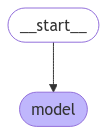

In [28]:
display(Image(app.get_graph().draw_mermaid_png()))

In [16]:
demo_ephemeral_chat_history = [
    HumanMessage(content="Hey there! I'm Nemo."),
    AIMessage(content="Hello!"),
    HumanMessage(content="How are you today?"),
    AIMessage(content="Fine thanks!"),
]

In [18]:
messages = app.invoke(
    {
        "messages": demo_ephemeral_chat_history
        + [HumanMessage("What did I say my name was?")]
    },
    config={"configurable": {"thread_id": "4"}},
)

for message in messages["messages"]:
    message.pretty_print()

================================== Ai Message ==================================

In the conversation, Nemo introduces themselves as Nemo and greets the AI assistant. Nemo then asks the assistant how they are feeling, to which the assistant responds that they are fine.
================================ Human Message =================================

What did I say my name was?
================================== Ai Message ==================================

You introduced yourself as Nemo.
